# Actor-Critic Reinforcement Learning:
Actor-critic learning is a reinforcement-learning technique in which you simultaneously learn a policy function and a value function. The policy function tells you how to make decisions, and the value function helps improve the training process for the value function.

Actor-critic methods are Temporal difference(TD) methods that have a separate memory structure to explicitly represent the policy independent of the value function. The policy structure is known as the actor, because it is used to select actions, and the estimated value function is known as the critic, because it criticizes the actions made by the actor. Learning is always on-policy: the critic must learn about and critique whatever policy is currently being followed by the actor. The critique takes the form of a TD error. This scalar signal is the sole output of the critic and drives all learning in both actor and critic
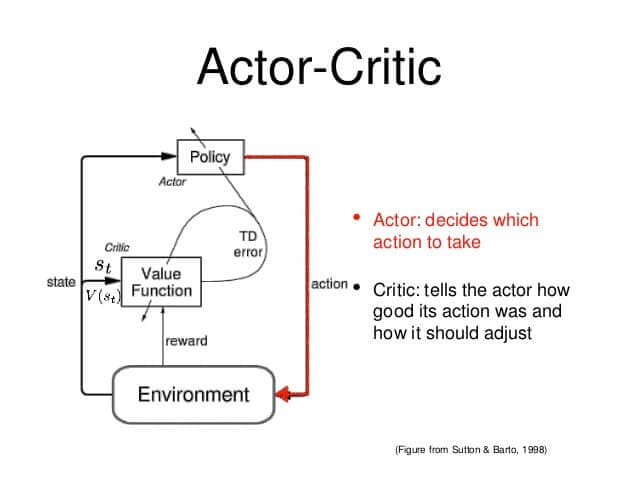


## Import Libraries:

In [1]:
from itertools import count
import torch
import numpy as np
import matplotlib.pyplot as plt

import gym_super_mario_bros
from gym.wrappers import Monitor
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT, RIGHT_ONLY
from nes_py.wrappers import JoypadSpace

from wrappers import wrapper
from agent import TwoNetAgent, TwoHeadAgent

## Setting Hyperparameters:

In [2]:
WORLD = 1
STAGE = 1
LEVEL_NAME = "SuperMarioBros-{}-{}-v1".format(WORLD, STAGE)
ACTION_SPACE = COMPLEX_MOVEMENT
FRAME_DIM = (84, 84, 4)
FRAME_SKIP = 4
NUM_EPISODES = 1001      #20_000
# LEARNING_RATE = 0.00003
ACTOR_LEARNING_RATE = 0.00005
CRITIC_LEARNING_RATE = 0.0005
GAMMA = 0.99
ENTROPY_SCALING = 0.01

RENDER_GAME = True
PLOT_INTERVAL = 200
VIDEO_INTERVAL = 200
CHECKPOINT_INTERVAL = 200
# MODEL_PATH = "C:\Users\kaila\OneDrive\Desktop\Reinforcement Learning\Deep_Reinforcement_Learning_Gym\Actor_Critic\saved_models"
ACTOR_MODEL_PATH = "./saved_models/actor_model_world1-11"
CRITIC_MODEL_PATH = "./saved_models/critic_model_world1-11"
# load saved model
LOAD_MODEL = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Available GPU: {torch.cuda.get_device_name(0)}")


Available GPU: GeForce GTX 1050 Ti with Max-Q Design


## Environment:
Creates the environment, applies some wrappers and returns it

In [4]:
def create_environment():
    tmp_env = gym_super_mario_bros.make(LEVEL_NAME)
    tmp_env = JoypadSpace(tmp_env, ACTION_SPACE)
    tmp_env = wrapper(tmp_env, FRAME_DIM, FRAME_SKIP)

    return tmp_env

## Plot Actor Critic Rewards and Loss:

In [5]:
# def plot_reward_history(reward_history, mean_reward_history, actor_loss_history, critic_loss_history):
def plot_reward_history(val1, val2, lbl1, lbl2, title):
    plt.figure(figsize=(12,6))
    plt.plot(val1, "#fcbe03", label = "t1")
    plt.plot(val2, "#03fcf4", label = "t1")
    plt.ylabel(lbl1, fontsize = 18)
    plt.xlabel(lbl2,fontsize = 18)
    plt.title(title, fontsize = 18)
    if lbl1 == "Reward":    
        plt.legend(['Reward History', 'Mean Reward History'])
    else:      
        plt.legend(['Actor Loss', 'Critic Loss'])
    plt.show()


## Convert Lazy Frame to Tensor:
pytorch expects the frames as height x width x depth

In [6]:
def lazy_frame_to_tensor(lazy_frame):
    return torch.from_numpy(
        np.expand_dims(np.asarray(lazy_frame).astype(np.float64).transpose((2, 1, 0)), axis=0)).float()

## Record Episode:
Record episode based on agent and Actions taken by Mario

In [7]:
def record_one_episode(agent, episode):
    tmp_env = gym_super_mario_bros.make(LEVEL_NAME)
    tmp_env = JoypadSpace(tmp_env, ACTION_SPACE)
    tmp_env = Monitor(tmp_env, './videos/video-episode-{0:05d}'.format(episode), force=True)
    tmp_env = wrapper(tmp_env, FRAME_DIM, FRAME_SKIP)

    state = lazy_frame_to_tensor(tmp_env.reset())

    total_reward = 0
    while True:
        action = agent.get_action(state)

        next_state, reward, done, info = tmp_env.step(action)
        next_state = lazy_frame_to_tensor(next_state)

        if done:
            break

        total_reward += reward
        state = next_state

## Training Mario

Episode: 1	 Reward: -53.00	 AverageReward: 0.00	 Actor Loss: -36.91930	 Critic Loss: 23.47063
Episode: 2	 Reward: 773.00	 AverageReward: 0.00	 Actor Loss: 109.32392	 Critic Loss: 66.41881
Episode: 3	 Reward: 748.00	 AverageReward: 0.00	 Actor Loss: 138.34778	 Critic Loss: 77.81081
Episode: 4	 Reward: 590.00	 AverageReward: 0.00	 Actor Loss: 344.87442	 Critic Loss: 150.12019
Episode: 5	 Reward: 1280.00	 AverageReward: 0.00	 Actor Loss: 490.42413	 Critic Loss: 221.40819
Episode: 6	 Reward: 169.00	 AverageReward: 0.00	 Actor Loss: 86.02321	 Critic Loss: 57.50409
Episode: 7	 Reward: 693.00	 AverageReward: 0.00	 Actor Loss: 354.50983	 Critic Loss: 181.97711
Episode: 8	 Reward: 608.00	 AverageReward: 0.00	 Actor Loss: 253.48824	 Critic Loss: 132.69557
Episode: 9	 Reward: 1342.00	 AverageReward: 0.00	 Actor Loss: 580.01410	 Critic Loss: 326.36597
Episode: 10	 Reward: 628.00	 AverageReward: 0.00	 Actor Loss: 381.30991	 Critic Loss: 213.54912
Episode: 11	 Reward: 1330.00	 AverageReward: 0.00	 A

Episode: 87	 Reward: 251.00	 AverageReward: 0.00	 Actor Loss: 16.64112	 Critic Loss: 34.72319
Episode: 88	 Reward: 885.00	 AverageReward: 0.00	 Actor Loss: 190.15671	 Critic Loss: 175.83418
Episode: 89	 Reward: 625.00	 AverageReward: 0.00	 Actor Loss: 154.92490	 Critic Loss: 128.66714
Episode: 90	 Reward: 676.00	 AverageReward: 0.00	 Actor Loss: 73.52116	 Critic Loss: 84.67502
Episode: 91	 Reward: 1121.00	 AverageReward: 0.00	 Actor Loss: 282.35107	 Critic Loss: 243.88292
Episode: 92	 Reward: 643.00	 AverageReward: 0.00	 Actor Loss: 43.95571	 Critic Loss: 86.73431
Episode: 93	 Reward: 236.00	 AverageReward: 0.00	 Actor Loss: -96.39623	 Critic Loss: 76.07843
Episode: 94	 Reward: 636.00	 AverageReward: 0.00	 Actor Loss: 38.04972	 Critic Loss: 76.86437
Episode: 95	 Reward: 676.00	 AverageReward: 0.00	 Actor Loss: 182.21214	 Critic Loss: 127.58008
Episode: 96	 Reward: 1424.00	 AverageReward: 0.00	 Actor Loss: 324.65369	 Critic Loss: 275.90417
Episode: 97	 Reward: 811.00	 AverageReward: 0.0

Episode: 172	 Reward: 631.00	 AverageReward: 0.00	 Actor Loss: 38.42648	 Critic Loss: 112.18937
Episode: 173	 Reward: 1390.00	 AverageReward: 0.00	 Actor Loss: 454.21146	 Critic Loss: 281.02530
Episode: 174	 Reward: 1432.00	 AverageReward: 0.00	 Actor Loss: 310.54501	 Critic Loss: 221.90363
Episode: 175	 Reward: 234.00	 AverageReward: 0.00	 Actor Loss: 22.82691	 Critic Loss: 25.08524
Episode: 176	 Reward: 816.00	 AverageReward: 0.00	 Actor Loss: 180.37885	 Critic Loss: 181.63275
Episode: 177	 Reward: 642.00	 AverageReward: 0.00	 Actor Loss: 229.99617	 Critic Loss: 144.66472
Episode: 178	 Reward: 1091.00	 AverageReward: 0.00	 Actor Loss: 265.74048	 Critic Loss: 205.17711
Episode: 179	 Reward: 1866.00	 AverageReward: 0.00	 Actor Loss: 447.13644	 Critic Loss: 370.11426
Episode: 180	 Reward: 1341.00	 AverageReward: 0.00	 Actor Loss: 436.76413	 Critic Loss: 304.02289
Episode: 181	 Reward: 700.00	 AverageReward: 0.00	 Actor Loss: 173.78632	 Critic Loss: 120.50394
Episode: 182	 Reward: 797.00

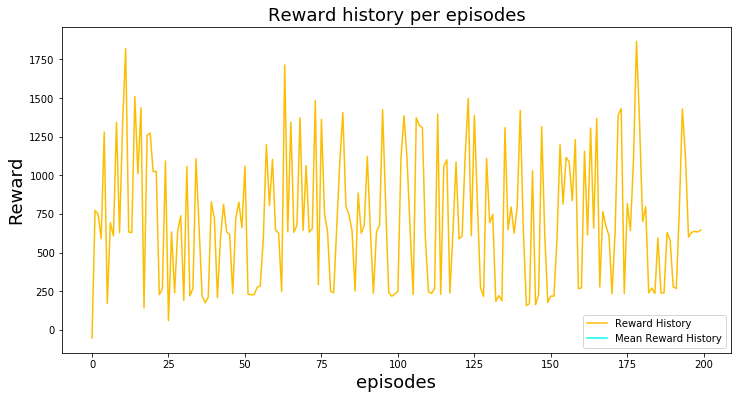

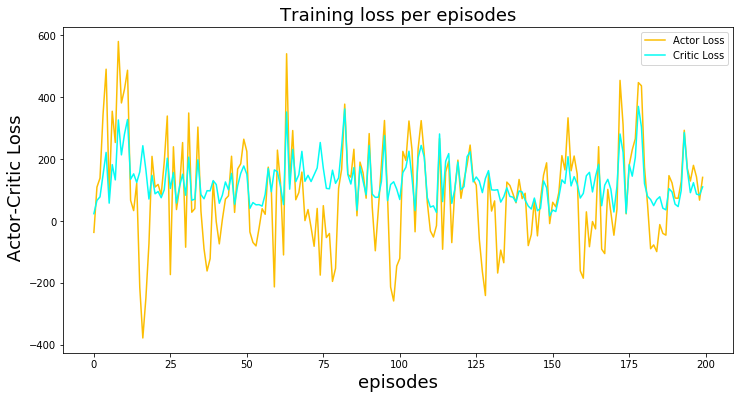

Episode: 201	 Reward: 1800.00	 AverageReward: 725.46	 Actor Loss: 396.40149	 Critic Loss: 296.64182
Episode: 202	 Reward: 271.00	 AverageReward: 722.95	 Actor Loss: -63.57296	 Critic Loss: 40.32387
Episode: 203	 Reward: 1133.00	 AverageReward: 724.87	 Actor Loss: 185.67307	 Critic Loss: 145.28534
Episode: 204	 Reward: 612.00	 AverageReward: 724.98	 Actor Loss: 58.80994	 Critic Loss: 109.55959
Episode: 205	 Reward: 643.00	 AverageReward: 721.79	 Actor Loss: 126.68726	 Critic Loss: 128.62808
Episode: 206	 Reward: 222.00	 AverageReward: 722.06	 Actor Loss: -223.86185	 Critic Loss: 111.01650
Episode: 207	 Reward: 671.00	 AverageReward: 721.95	 Actor Loss: 38.52151	 Critic Loss: 121.83469
Episode: 208	 Reward: 1295.00	 AverageReward: 725.38	 Actor Loss: 157.52550	 Critic Loss: 156.62129
Episode: 209	 Reward: 255.00	 AverageReward: 719.95	 Actor Loss: -182.47743	 Critic Loss: 86.08820
Episode: 210	 Reward: 173.00	 AverageReward: 717.67	 Actor Loss: -246.82587	 Critic Loss: 125.78524
Episode:

Episode: 284	 Reward: 816.00	 AverageReward: 709.78	 Actor Loss: 90.78916	 Critic Loss: 109.52452
Episode: 285	 Reward: 661.00	 AverageReward: 709.37	 Actor Loss: 242.24013	 Critic Loss: 142.12346
Episode: 286	 Reward: 640.00	 AverageReward: 709.36	 Actor Loss: 148.73758	 Critic Loss: 108.14200
Episode: 287	 Reward: 652.00	 AverageReward: 711.36	 Actor Loss: 220.95178	 Critic Loss: 143.31387
Episode: 288	 Reward: 623.00	 AverageReward: 710.05	 Actor Loss: 135.13037	 Critic Loss: 94.54816
Episode: 289	 Reward: 243.00	 AverageReward: 708.14	 Actor Loss: -96.24910	 Critic Loss: 49.05288
Episode: 290	 Reward: 667.00	 AverageReward: 708.10	 Actor Loss: 127.98560	 Critic Loss: 108.97289
Episode: 291	 Reward: 1350.00	 AverageReward: 709.24	 Actor Loss: 166.84372	 Critic Loss: 160.33231
Episode: 292	 Reward: 611.00	 AverageReward: 709.08	 Actor Loss: 90.33732	 Critic Loss: 105.63974
Episode: 293	 Reward: 1046.00	 AverageReward: 713.13	 Actor Loss: 51.74706	 Critic Loss: 84.13870
Episode: 294	 

Episode: 367	 Reward: 830.00	 AverageReward: 712.16	 Actor Loss: 160.64160	 Critic Loss: 199.86635
Episode: 368	 Reward: 1869.00	 AverageReward: 717.68	 Actor Loss: 525.68262	 Critic Loss: 424.77310
Episode: 369	 Reward: 1399.00	 AverageReward: 721.32	 Actor Loss: 371.16217	 Critic Loss: 288.47623
Episode: 370	 Reward: 247.00	 AverageReward: 719.50	 Actor Loss: -13.20074	 Critic Loss: 19.68569
Episode: 371	 Reward: 250.00	 AverageReward: 719.60	 Actor Loss: -31.54575	 Critic Loss: 25.73619
Episode: 372	 Reward: 1117.00	 AverageReward: 722.02	 Actor Loss: 134.06161	 Critic Loss: 139.60954
Episode: 373	 Reward: 1216.00	 AverageReward: 721.15	 Actor Loss: 262.05798	 Critic Loss: 229.12943
Episode: 374	 Reward: 635.00	 AverageReward: 717.17	 Actor Loss: 125.91048	 Critic Loss: 137.39124
Episode: 375	 Reward: 669.00	 AverageReward: 719.35	 Actor Loss: 9.90294	 Critic Loss: 126.96330
Episode: 376	 Reward: 607.00	 AverageReward: 718.30	 Actor Loss: 26.25673	 Critic Loss: 119.12556
Episode: 37

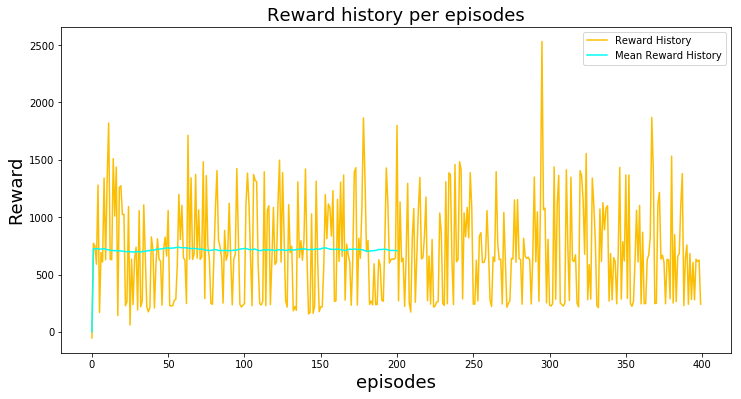

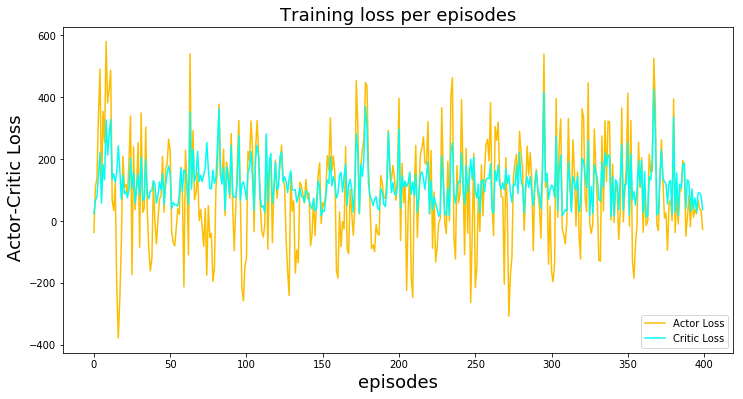

Episode: 401	 Reward: 234.00	 AverageReward: 699.82	 Actor Loss: -25.27535	 Critic Loss: 32.88229
Episode: 402	 Reward: 631.00	 AverageReward: 701.62	 Actor Loss: 66.67384	 Critic Loss: 94.77484
Episode: 403	 Reward: 658.00	 AverageReward: 699.24	 Actor Loss: 121.18269	 Critic Loss: 116.84001
Episode: 404	 Reward: 281.00	 AverageReward: 697.59	 Actor Loss: 24.97589	 Critic Loss: 37.23590
Episode: 405	 Reward: 1092.00	 AverageReward: 699.83	 Actor Loss: 149.84045	 Critic Loss: 186.19783
Episode: 406	 Reward: 602.00	 AverageReward: 701.73	 Actor Loss: 54.68551	 Critic Loss: 72.07808
Episode: 407	 Reward: 613.00	 AverageReward: 701.44	 Actor Loss: 94.29636	 Critic Loss: 101.73389
Episode: 408	 Reward: 651.00	 AverageReward: 698.22	 Actor Loss: 79.41754	 Critic Loss: 106.76321
Episode: 409	 Reward: 1431.00	 AverageReward: 704.10	 Actor Loss: 248.86710	 Critic Loss: 287.03125
Episode: 410	 Reward: 237.00	 AverageReward: 704.42	 Actor Loss: -37.05138	 Critic Loss: 52.33907
Episode: 411	 Rewa

Episode: 485	 Reward: 790.00	 AverageReward: 730.79	 Actor Loss: 15.19945	 Critic Loss: 77.27676
Episode: 486	 Reward: 644.00	 AverageReward: 730.81	 Actor Loss: 95.22172	 Critic Loss: 104.19601
Episode: 487	 Reward: 611.00	 AverageReward: 730.61	 Actor Loss: 54.08749	 Critic Loss: 85.41524
Episode: 488	 Reward: 1073.00	 AverageReward: 732.86	 Actor Loss: 91.58256	 Critic Loss: 142.14067
Episode: 489	 Reward: 775.00	 AverageReward: 735.51	 Actor Loss: 43.49997	 Critic Loss: 76.26566
Episode: 490	 Reward: 1676.00	 AverageReward: 740.56	 Actor Loss: 362.81754	 Critic Loss: 275.90247
Episode: 491	 Reward: 1356.00	 AverageReward: 740.59	 Actor Loss: 111.32558	 Critic Loss: 110.27370
Episode: 492	 Reward: 1468.00	 AverageReward: 744.88	 Actor Loss: 266.42264	 Critic Loss: 217.27177
Episode: 493	 Reward: 1371.00	 AverageReward: 746.50	 Actor Loss: 119.62164	 Critic Loss: 120.34361
Episode: 494	 Reward: 262.00	 AverageReward: 746.48	 Actor Loss: -163.87061	 Critic Loss: 131.06854
Episode: 495

Episode: 569	 Reward: 763.00	 AverageReward: 741.87	 Actor Loss: 121.17676	 Critic Loss: 100.92311
Episode: 570	 Reward: 199.00	 AverageReward: 741.62	 Actor Loss: -19.98338	 Critic Loss: 17.19824
Episode: 571	 Reward: 635.00	 AverageReward: 743.55	 Actor Loss: 114.81170	 Critic Loss: 92.20968
Episode: 572	 Reward: 236.00	 AverageReward: 739.14	 Actor Loss: 6.99510	 Critic Loss: 10.86610
Episode: 573	 Reward: 637.00	 AverageReward: 736.25	 Actor Loss: 104.75999	 Critic Loss: 81.16347
Episode: 574	 Reward: 773.00	 AverageReward: 736.94	 Actor Loss: 127.10596	 Critic Loss: 90.92644
Episode: 575	 Reward: 809.00	 AverageReward: 737.64	 Actor Loss: 90.51597	 Critic Loss: 71.08202
Episode: 576	 Reward: 253.00	 AverageReward: 735.87	 Actor Loss: -5.67927	 Critic Loss: 29.59708
Episode: 577	 Reward: 601.00	 AverageReward: 737.65	 Actor Loss: 45.16724	 Critic Loss: 61.24083
Episode: 578	 Reward: 257.00	 AverageReward: 735.77	 Actor Loss: -26.79702	 Critic Loss: 31.54569
Episode: 579	 Reward: 22

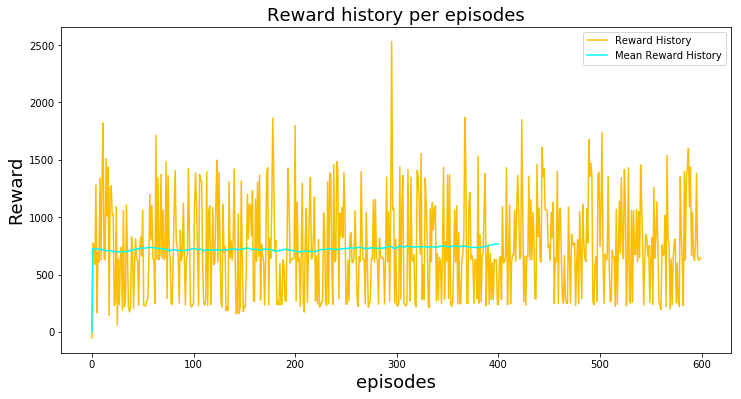

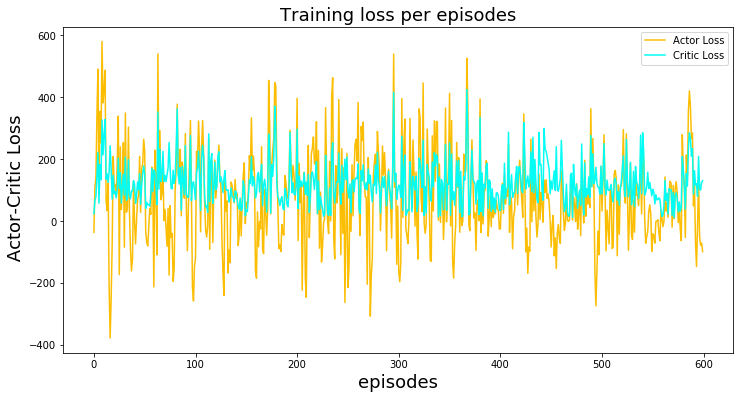

Episode: 601	 Reward: 1799.00	 AverageReward: 775.70	 Actor Loss: 192.64973	 Critic Loss: 211.19080
Episode: 602	 Reward: 1378.00	 AverageReward: 779.43	 Actor Loss: 32.81272	 Critic Loss: 96.12048
Episode: 603	 Reward: 605.00	 AverageReward: 779.16	 Actor Loss: -53.67081	 Critic Loss: 112.95412
Episode: 604	 Reward: 252.00	 AverageReward: 779.02	 Actor Loss: -266.40668	 Critic Loss: 240.15948
Episode: 605	 Reward: 2077.00	 AverageReward: 783.95	 Actor Loss: 361.77103	 Critic Loss: 362.33759
Episode: 606	 Reward: 627.00	 AverageReward: 784.07	 Actor Loss: -32.78499	 Critic Loss: 77.05282
Episode: 607	 Reward: 247.00	 AverageReward: 782.24	 Actor Loss: -260.53745	 Critic Loss: 176.28928
Episode: 608	 Reward: 1369.00	 AverageReward: 785.83	 Actor Loss: 219.42546	 Critic Loss: 290.39478
Episode: 609	 Reward: 877.00	 AverageReward: 783.06	 Actor Loss: 17.56248	 Critic Loss: 175.53883
Episode: 610	 Reward: 1493.00	 AverageReward: 789.34	 Actor Loss: 328.07376	 Critic Loss: 316.99194
Episode

Episode: 684	 Reward: 823.00	 AverageReward: 826.69	 Actor Loss: -30.59342	 Critic Loss: 87.72953
Episode: 685	 Reward: 647.00	 AverageReward: 825.98	 Actor Loss: 9.87355	 Critic Loss: 98.91059
Episode: 686	 Reward: 765.00	 AverageReward: 826.58	 Actor Loss: 13.80574	 Critic Loss: 106.06423
Episode: 687	 Reward: 1069.00	 AverageReward: 828.87	 Actor Loss: -64.87758	 Critic Loss: 94.94536
Episode: 688	 Reward: 235.00	 AverageReward: 824.68	 Actor Loss: -237.49992	 Critic Loss: 207.83902
Episode: 689	 Reward: 1077.00	 AverageReward: 826.19	 Actor Loss: 66.25961	 Critic Loss: 138.03682
Episode: 690	 Reward: 673.00	 AverageReward: 821.17	 Actor Loss: -142.28426	 Critic Loss: 117.18060
Episode: 691	 Reward: 646.00	 AverageReward: 817.62	 Actor Loss: -39.03823	 Critic Loss: 93.04584
Episode: 692	 Reward: 1089.00	 AverageReward: 815.73	 Actor Loss: 13.41322	 Critic Loss: 113.47346
Episode: 693	 Reward: 892.00	 AverageReward: 813.34	 Actor Loss: -33.62313	 Critic Loss: 133.10321
Episode: 694	 

Episode: 767	 Reward: 185.00	 AverageReward: 864.90	 Actor Loss: -334.64767	 Critic Loss: 159.22772
Episode: 768	 Reward: 774.00	 AverageReward: 864.73	 Actor Loss: 154.65720	 Critic Loss: 87.33620
Episode: 769	 Reward: 239.00	 AverageReward: 862.11	 Actor Loss: -175.56384	 Critic Loss: 77.09811
Episode: 770	 Reward: 1120.00	 AverageReward: 866.72	 Actor Loss: 290.59918	 Critic Loss: 163.68362
Episode: 771	 Reward: 619.00	 AverageReward: 866.63	 Actor Loss: 237.34404	 Critic Loss: 122.70987
Episode: 772	 Reward: 606.00	 AverageReward: 868.49	 Actor Loss: 134.68279	 Critic Loss: 76.50285
Episode: 773	 Reward: 234.00	 AverageReward: 866.47	 Actor Loss: -42.11977	 Critic Loss: 30.14437
Episode: 774	 Reward: 227.00	 AverageReward: 863.74	 Actor Loss: -59.32434	 Critic Loss: 29.83912
Episode: 775	 Reward: 264.00	 AverageReward: 861.01	 Actor Loss: 33.78039	 Critic Loss: 28.82533
Episode: 776	 Reward: 183.00	 AverageReward: 860.66	 Actor Loss: -106.43125	 Critic Loss: 46.65349
Episode: 777	 

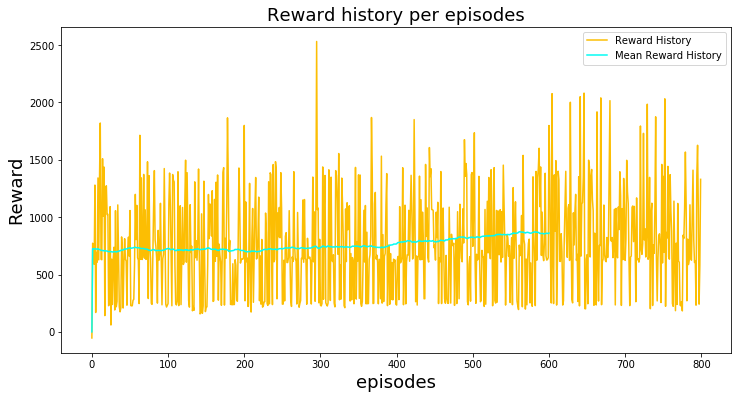

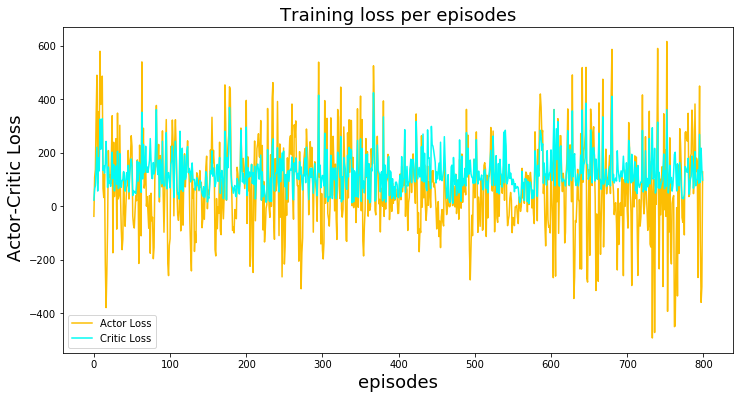

Episode: 801	 Reward: 769.00	 AverageReward: 856.59	 Actor Loss: -169.29176	 Critic Loss: 77.62437
Episode: 802	 Reward: 1104.00	 AverageReward: 855.22	 Actor Loss: 37.66403	 Critic Loss: 111.14016
Episode: 803	 Reward: 791.00	 AverageReward: 856.15	 Actor Loss: -189.52948	 Critic Loss: 93.05241
Episode: 804	 Reward: 591.00	 AverageReward: 857.85	 Actor Loss: -129.46342	 Critic Loss: 91.69279
Episode: 805	 Reward: 625.00	 AverageReward: 850.59	 Actor Loss: -118.58936	 Critic Loss: 86.01992
Episode: 806	 Reward: 251.00	 AverageReward: 848.71	 Actor Loss: -288.91223	 Critic Loss: 150.97433
Episode: 807	 Reward: 635.00	 AverageReward: 850.64	 Actor Loss: -18.02009	 Critic Loss: 72.98180
Episode: 808	 Reward: 1149.00	 AverageReward: 849.54	 Actor Loss: 265.23395	 Critic Loss: 155.84131
Episode: 809	 Reward: 637.00	 AverageReward: 848.35	 Actor Loss: -15.73166	 Critic Loss: 58.43869
Episode: 810	 Reward: 646.00	 AverageReward: 844.11	 Actor Loss: 106.95432	 Critic Loss: 82.08124
Episode: 81

Episode: 884	 Reward: 631.00	 AverageReward: 833.73	 Actor Loss: -62.41013	 Critic Loss: 91.18573
Episode: 885	 Reward: 1355.00	 AverageReward: 837.27	 Actor Loss: 116.51247	 Critic Loss: 101.97160
Episode: 886	 Reward: 768.00	 AverageReward: 837.28	 Actor Loss: -46.56583	 Critic Loss: 92.02423
Episode: 887	 Reward: 216.00	 AverageReward: 833.02	 Actor Loss: -425.09055	 Critic Loss: 190.85762
Episode: 888	 Reward: 1099.00	 AverageReward: 837.34	 Actor Loss: 147.65199	 Critic Loss: 150.45120
Episode: 889	 Reward: 686.00	 AverageReward: 835.38	 Actor Loss: -5.81106	 Critic Loss: 84.96482
Episode: 890	 Reward: 219.00	 AverageReward: 833.12	 Actor Loss: -308.79477	 Critic Loss: 170.30042
Episode: 891	 Reward: 707.00	 AverageReward: 833.42	 Actor Loss: 44.99777	 Critic Loss: 97.57495
Episode: 892	 Reward: 616.00	 AverageReward: 831.05	 Actor Loss: 8.30512	 Critic Loss: 93.26840
Episode: 893	 Reward: 649.00	 AverageReward: 829.84	 Actor Loss: 54.29512	 Critic Loss: 75.16759
Episode: 894	 Rew

Episode: 967	 Reward: 834.00	 AverageReward: 824.59	 Actor Loss: 133.41470	 Critic Loss: 84.73228
Episode: 968	 Reward: 257.00	 AverageReward: 822.00	 Actor Loss: -119.50210	 Critic Loss: 54.84618
Episode: 969	 Reward: 668.00	 AverageReward: 824.15	 Actor Loss: 113.86411	 Critic Loss: 94.60944
Episode: 970	 Reward: 1058.00	 AverageReward: 823.84	 Actor Loss: 227.27295	 Critic Loss: 123.30540
Episode: 971	 Reward: 767.00	 AverageReward: 824.58	 Actor Loss: 83.11214	 Critic Loss: 59.53564
Episode: 972	 Reward: 1083.00	 AverageReward: 826.97	 Actor Loss: 246.22966	 Critic Loss: 145.78876
Episode: 973	 Reward: 872.00	 AverageReward: 830.15	 Actor Loss: 202.21291	 Critic Loss: 113.12495
Episode: 974	 Reward: 272.00	 AverageReward: 830.38	 Actor Loss: -101.35425	 Critic Loss: 50.02287
Episode: 975	 Reward: 813.00	 AverageReward: 833.12	 Actor Loss: 261.55334	 Critic Loss: 143.43932
Episode: 976	 Reward: 572.00	 AverageReward: 835.07	 Actor Loss: 9.41714	 Critic Loss: 62.90144
Episode: 977	 R

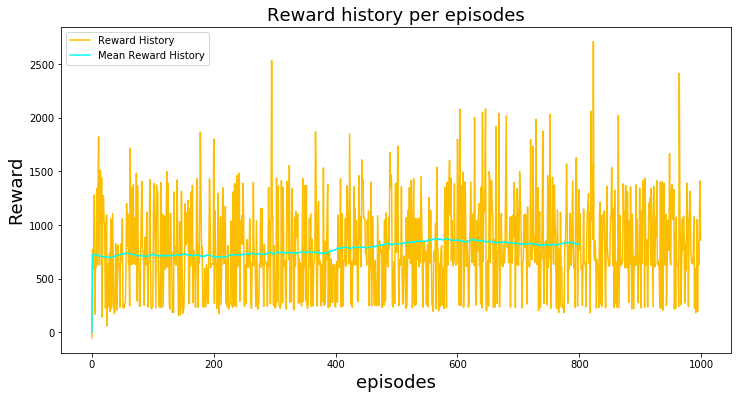

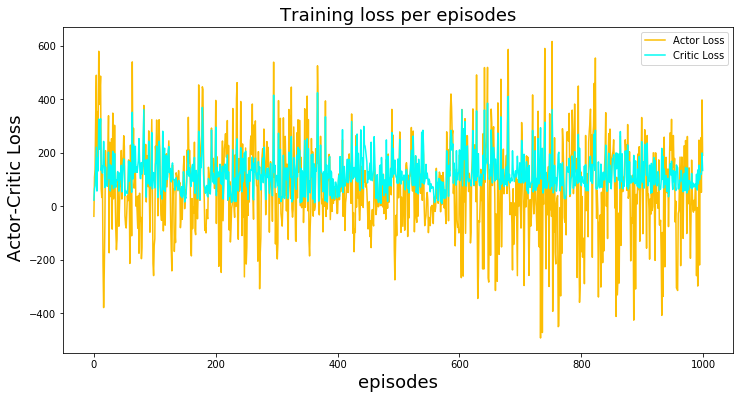

In [8]:
"""" Running mario"""
env = create_environment()
# set all options for reproducability
env.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

agent = TwoNetAgent(frame_dim=FRAME_DIM, action_space_size=env.action_space.n, lr_actor=ACTOR_LEARNING_RATE,
                    lr_critic=CRITIC_LEARNING_RATE, gamma=GAMMA, entropy_scaling=ENTROPY_SCALING,
                    device=DEVICE)
if LOAD_MODEL:
    agent.load_model(actor_model_path=ACTOR_MODEL_PATH, critic_model_path=CRITIC_MODEL_PATH)

# record_one_episode(agent, 1)

reward_history = []
mean_reward_history = [0]
actor_loss_history = []
critic_loss_history = []
for episode in range(1, NUM_EPISODES):

    # reset the environment before a new episode
    state = env.reset()
    state = lazy_frame_to_tensor(state)

    trajectory = []
    total_episode_reward = 0
    total_episode_score = 0
    for step in count(1):
        # get the next action
        action = agent.get_action(state)
        # preform the action
        next_state, reward, done, info = env.step(action)
        next_state = lazy_frame_to_tensor(next_state)

        # add the score to the reward. 4 reward for 100 points
        score_delta = (info["score"] - total_episode_score)
        total_episode_score += score_delta
        reward += (score_delta / 5)

        # add the transition to the trajectory
        trajectory.append([state, action, reward, done])

        # keep track of the total reward
        total_episode_reward += reward

        if done:
            if info["flag_get"]:
                print("Finished Level")
            reward_history.append(total_episode_reward)
                        
            if episode > 200:
                mean_reward_history.append(np.mean(reward_history[-200:]))
            break

        if RENDER_GAME:
            env.render()

        del state
        state = next_state

    # update the model using the trajectory
    actor_loss, critic_loss = agent.update(trajectory)
    actor_loss_history.append(actor_loss)
    critic_loss_history.append(critic_loss)
    print("Episode: {}\t Reward: {:.2f}\t AverageReward: {:.2f}\t Actor Loss: {:.5f}\t Critic Loss: {:.5f}".format(
        episode, total_episode_reward, mean_reward_history[-1], actor_loss, critic_loss))

    if episode % PLOT_INTERVAL == 0:
        plot_reward_history(reward_history, mean_reward_history, "Reward", "episodes", "Reward history per episodes")
        plot_reward_history(actor_loss_history, critic_loss_history, " Actor-Critic Loss", "episodes", "Training loss per episodes")        
        
#     if episode % VIDEO_INTERVAL == 0:
#         record_one_episode(agent, episode)
#     if episode % CHECKPOINT_INTERVAL == 0:
#         agent.save_model(actor_model_path=ACTOR_MODEL_PATH, critic_model_path=CRITIC_MODEL_PATH)
    if total_episode_reward >= 1400 or info["flag_get"]: 
        record_one_episode(agent, episode)
        agent.save_model(actor_model_path=ACTOR_MODEL_PATH, critic_model_path=CRITIC_MODEL_PATH)

env.close()
